In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import get_lags
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [4]:
full = full.loc["1948-01-01":]

In [5]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [6]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

core = full[core_series]

train = core.iloc[:val_start-1]
validation = core.iloc[val_start:test_start-1]
test = core.iloc[test_start:]

print(train.shape)

(681, 3)


In [7]:
def get_median(X):
    dists = pdist(X, 'euclidean')
    dists = np.square(dists)
    return np.median(dists)


In [8]:
kernels = ["polynomial", "rbf"]
alphas = np.logspace(-6, 6, 13)
mses = {}

for lags in range(1, 15):

    X = get_lags(train, lags=lags)
    X = X[lags:]
    y = train[lags:]
    
    for kernel in kernels:
        for alpha in alphas:
            if kernel == 'rbf':
                model = KernelRidge(kernel=kernel, alpha=alpha, gamma=1/get_median(X))
            else:
                model = KernelRidge(kernel=kernel, alpha=alpha)
            model.fit(X, y)
            y_pred = model.predict(get_lags(validation, lags)[lags:])
            loss = mean_squared_error(y_pred, validation[lags:])
            mses["%d-%s-%f" % (lags, kernel, alpha)] = loss
                


In [9]:
# just checking the shapes are correct for the loss
print(y_pred.shape)
print(validation[lags:].shape)

(71, 3)
(71, 3)


In [10]:
# best one

lowest = 10000000

for k, v in mses.items():
    if v < lowest:
        lowest = v
        lowest_key = k
        
print(lowest_key, lowest)

2-polynomial-0.000001 0.028915246149717782


In [72]:
alphas

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

In [79]:
polynomial = []
rbf = []

for k, v in mses.items():
    if k.split("-")[1] == "polynomial" and k.split("-")[2] == "0.100000":
        polynomial.append(v)
    if k.split("-")[1] == "rbf" and k.split("-")[2] == "0.100000":
        rbf.append(v)
        

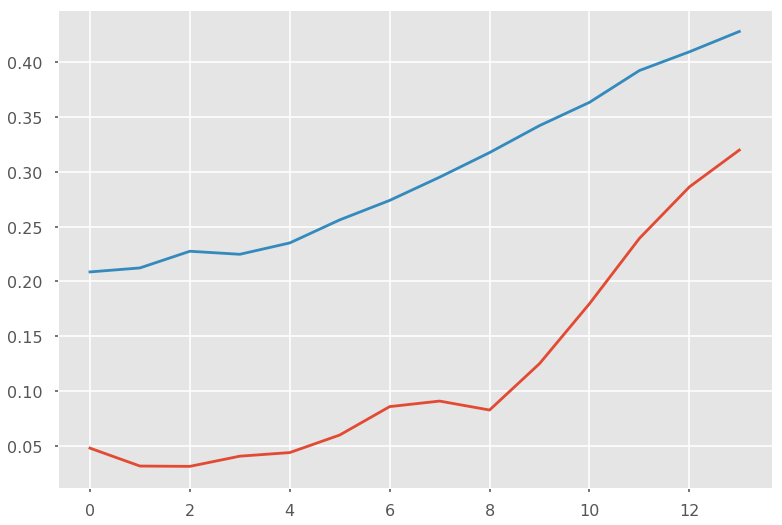

In [80]:
plt.plot(polynomial)
plt.plot(rbf)

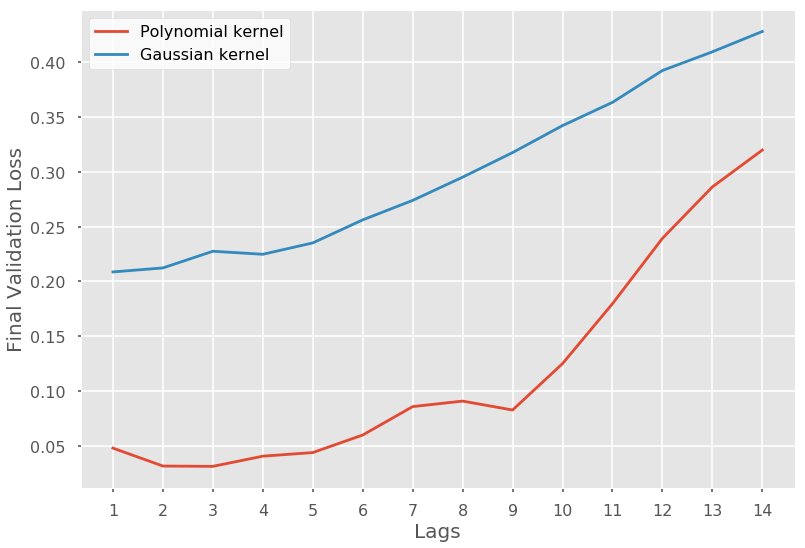

In [81]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(polynomial) + 1)], polynomial)
plt.plot([i for i in range(1, len(rbf) + 1)], rbf)

plt.xticks([i for i in range(1, 15)])

plt.legend(("Polynomial kernel", "Gaussian kernel"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_kernel_core.png', bbox_inches='tight')

# Forecasts

In [11]:
lags = 2

X = get_lags(train, lags=lags)
X = X[lags:]
y = train[lags:]

In [14]:
model = KernelRidge(kernel='polynomial', alpha=0.000001)
model.fit(X, y)

y_pred = model.predict(get_lags(test, lags)[lags:])
loss = mean_squared_error(y_pred, test[lags:])

In [15]:
loss

0.008656769710167683

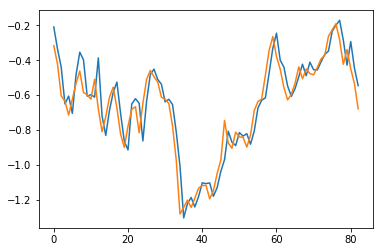

In [20]:
plt.plot(y_pred[:, 0])
plt.plot(test.values[lags:, 0])

# Multi-step

In [23]:
multitest = get_lags(test, lags)[lags:]

steps = 3

In [52]:
y_pred_multi = np.empty((len(test) - lags - steps, 3))

for i in range(len(test) - lags - steps):
    y_pred_1 = model.predict(multitest.values[i].reshape(1, -1)) # first step
    y_pred_2 = model.predict(np.concatenate((multitest.values[i][3:].reshape(1, -1), y_pred_1), axis=1))
    y_pred_3 = model.predict(np.concatenate((y_pred_1, y_pred_2), axis=1))
    y_pred_multi[i] = y_pred_3

loss = mean_squared_error(y_pred_multi, test[lags+steps:])

In [53]:
loss

0.045478296850858045

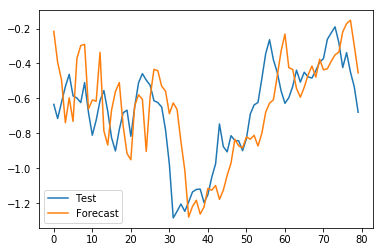

In [56]:
plt.plot(test.values[lags+steps:,0])
plt.plot(y_pred_multi[:,0])
plt.legend(("Test", "Forecast"), facecolor="white")

In [57]:
len(y_pred_multi)

80